### Modelling Pipeline. 
This file produces the results table. It runs through the entire modelling pipline (except grid search). 
1. Load and process training data according to modelling pipeline
2. Define estimators based on previous grid search
3. Fit models
4. Evaluate models in-sample (train + crossval). 
5. Load and process test data according to modelling pipeline 
6. Evaluate models out-of-sample
7. Send result table to LaTeX.

In [3]:
import pandas as pd 
import numpy as np
import os 
import sys 
import matplotlib.pyplot as plt
import seaborn as sns
#path = r'C:\Users\rbjoe\Dropbox\Kugejl\10.semester\Topics in Social Data Science\ExamProject\data'
path = r'C:\Users\nynne\Dropbox\Polit\Topics in Social Data Science\ExamProject\data'


np.random.seed(33)

from datetime import datetime 
time_start = datetime.now()

###############################################################################
### LOAD DATA
data_train = pd.read_csv(path + '\data_train.csv', index_col=0)
#data_train = data_train[data_train['league']=='England Premier League']
y = data_train['draw']
odds_prob = data_train['odds_prob_draw']
x = data_train[['ELO_home', 'ELO_away', 'home_agg_overall', 'home_def_overall',
                'away_agg_overall', 'away_def_overall', 'RR']]
x = x.join(pd.get_dummies(data_train['league']))#.reset_index(drop='index')))


###############################################################################
### IMPUTATION 
#Check for missing values 
print('Rows with any missing values:', round(x.isnull().any(axis=1).sum()/len(x),2))
print('Missing values:\n', x.isnull().sum(), sep='')

## Performance metrics are missing because of burn-in.
## Fillout burnin based on later average. 
x = x.join(data_train[['team_home', 'team_awat']])
#x['home_agg_overall'] = x.groupby('team_home').transform(lambda a: a.fillna(a.mean()))
x.loc[x['home_agg_overall'].isnull(), 'home_agg_overall'] = x.groupby('team_home')['home_agg_overall'].transform('mean')
x.loc[x['home_def_overall'].isnull(), 'home_def_overall'] = x.groupby('team_home')['home_def_overall'].transform('mean')
x.loc[x['away_agg_overall'].isnull(), 'away_agg_overall'] = x.groupby('team_awat')['away_agg_overall'].transform('mean')
x.loc[x['away_def_overall'].isnull(), 'away_def_overall'] = x.groupby('team_awat')['away_def_overall'].transform('mean')
x.drop(['team_home', 'team_awat'], axis=1, inplace=True)

#from sklearn.preprocessing import Imputer
#x = Imputer(strategy='mean').fit_transform()
x = x.fillna(x.mean())


print('Rows with any missing values:', round(x.isnull().any(axis=1).sum()/len(x),2))
#print('Missing values:\n', x.isnull().sum(), sep='')

###############################################################################
### STANDARDIZE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x.iloc[:,:7])
x.iloc[:,:7] = scaler.transform(x.iloc[:,:7])

###############################################################################
### GRID SEARCH 
    # See attached files. Optimal parameters are used below. 



Rows with any missing values: 0.42
Missing values:
ELO_home                    3899
ELO_away                    3897
home_agg_overall            1076
home_def_overall            1076
away_agg_overall            1066
away_def_overall            1066
RR                          1288
Belgium Jupiler League         0
England Premier League         0
France Ligue 1                 0
Germany 1. Bundesliga          0
Italy Serie A                  0
Netherlands Eredivisie         0
Poland Ekstraklasa             0
Portugal Liga ZON Sagres       0
Scotland Premier League        0
Spain LIGA BBVA                0
Switzerland Super League       0
dtype: int64
Rows with any missing values: 0.0


In [2]:
###############################################################################
### DEFINE ESTIMATORS 

estimators = {} 

#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
estimators['Logit (II)'] = LogisticRegression(penalty = 'l2', C = 18.340)
estimators['Logit (I)'] = LogisticRegression(penalty = 'l1', C = 1.1993961020353856)

#Random forest 
from sklearn.ensemble import RandomForestClassifier
estimators['RF (I)'] = RandomForestClassifier(max_depth=None, 
                             max_features='auto', 
                             min_samples_leaf = 100,
                             n_estimators = 1600,
                             min_samples_split = 2,
                             criterion = 'entropy',
                             bootstrap = True)
estimators['RF (II)'] = RandomForestClassifier(bootstrap = True, 
                             max_depth=None, 
                             max_features='auto', 
                             min_samples_leaf = 200,
                             min_samples_split = 2,
                             criterion = 'entropy',
                             n_estimators = 600)

#Neural network
from sklearn.neural_network import MLPClassifier
estimators['NN (I)'] = MLPClassifier(hidden_layer_sizes = (29,), 
                                    activation='relu', solver='adam', 
                                    alpha = 10**-4, 
                                    learning_rate_init = 10**-3,
                                    early_stopping =False, 
                                    tol = 10**-4, 
                                    max_iter=300) 
estimators['NN (II)'] = MLPClassifier(hidden_layer_sizes = (13,20), 
                                    activation='relu', solver='adam', 
                                    alpha = 10**-3, 
                                    learning_rate_init = 10**-3,
                                    early_stopping =False, 
                                    tol = 10**-4, 
                                    max_iter=300) 

###############################################################################
### TRAIN ESTIMATORS 
for estimator in estimators: 
    if estimator=='Logit (II)': 
        x_logit = pd.DataFrame(PolynomialFeatures().fit_transform(x))
        estimators[estimator].fit(x_logit,y)
    else: 
        estimators[estimator].fit(x,y)
    print('Finished fitting ', estimator, '.', sep='')


Finished fitting Logit (II).
Finished fitting Logit (I).
Finished fitting RF (I).
Finished fitting RF (II).
Finished fitting NN (I).
Finished fitting NN (II).


In [3]:
###############################################################################
### EVALUATE ESTIMATORS ON TRAIN DATA
def bet_income(y, prob, odds_prob, bet=1, threshold=0.0):
    will_bet = (prob>odds_prob+threshold) #Bet if probability high enough
    correct_bets = y[will_bet]          # Bet is correct if y==1. Select chosen bets. 
    odds = 1/odds_prob[will_bet]        # Calculate odds 
    
    #Calculate income    
    income = correct_bets*odds*bet-will_bet*bet
    income = income.sum() #Sum over matrix 
    
    #Calculate income as multiplicator of necessary capital
    if will_bet.sum() != 0: 
        income_factor = income/will_bet.sum() #
    else: income_factor = 0
    
    return income_factor

### In-sample 
prob_train, incoming_train = {}, {}
incoming_train['All'] = bet_income(y, np.ones(len(y)), odds_prob)

for estimator in estimators: 
    if estimator=='Logit (II)':
        prob_train[estimator] = estimators[estimator].predict_proba(x_logit)[:,1]
    else: 
        prob_train[estimator] = estimators[estimator].predict_proba(x)[:,1]
    incoming_train[estimator] = bet_income(y, prob_train[estimator], odds_prob)
    

### Cross-validation
from sklearn.model_selection import KFold
def cross_val_bet(estimator, x, y, odds_prob):
    fold = KFold(n_splits=10, shuffle=True)
    profit = []
    for train, test in fold.split(x): 
        estimator.fit(x.iloc[train], y.iloc[train])
        yprob = estimator.predict_proba(x.iloc[test])
        profit.append(bet_income(y.iloc[test], yprob[:,1], odds_prob.iloc[test]))
    
    return np.mean(profit)

incoming_cv = {}
incoming_cv['All'] = np.nan
for estimator in estimators: 
    if estimator=='Logit (II)':
        incoming_cv[estimator] = cross_val_bet(estimators[estimator], x_logit, y, odds_prob)
    else: 
        incoming_cv[estimator] = cross_val_bet(estimators[estimator], x, y, odds_prob)
    print('Finished cross-validation for ', estimator, '.', sep='')


Finished cross-validation for Logit (II).
Finished cross-validation for Logit (I).
Finished cross-validation for RF (I).
Finished cross-validation for RF (II).
Finished cross-validation for NN (I).
Finished cross-validation for NN (II).


In [4]:
###############################################################################
### LOAD AND PROCESS TEST DATA 

### LOAD DATA
data_test = pd.read_csv(path+'\data_test.csv', index_col=0)
#data_test = data_test[data_test['league']=='England Premier League']
y_test = data_test['draw']
odds_prob_test = data_test['odds_prob_draw']
x_test = data_test[['ELO_home', 'ELO_away', 'home_agg_overall', 'home_def_overall',
                'away_agg_overall', 'away_def_overall', 'RR']]
x_test = x_test.join(pd.get_dummies(data_test['league']))#.reset_index(drop='index')))
 
### Impute  (MUST USE VALUES FROM TRAIN!!!!!!!!!!!!)
x_test = x_test.join(data_train[['team_home', 'team_awat']])
#x['home_agg_overall'] = x.groupby('team_home').transform(lambda a: a.fillna(a.mean()))
x_test.loc[x_test['home_agg_overall'].isnull(), 'home_agg_overall'] = data_train.groupby('team_home')['home_agg_overall'].transform('mean')
x_test.loc[x_test['home_def_overall'].isnull(), 'home_def_overall'] = data_train.groupby('team_home')['home_def_overall'].transform('mean')
x_test.loc[x_test['away_agg_overall'].isnull(), 'away_agg_overall'] = data_train.groupby('team_awat')['away_agg_overall'].transform('mean')
x_test.loc[x_test['away_def_overall'].isnull(), 'away_def_overall'] = data_train.groupby('team_awat')['away_def_overall'].transform('mean')
x_test.drop(['team_home', 'team_awat'], axis=1, inplace=True)

x_test = x_test.fillna(data_train[['ELO_home', 'ELO_away', 'home_agg_overall', 'home_def_overall',
                'away_agg_overall', 'away_def_overall', 'RR']].mean())

#Standardization (fitted on train stuff)
x_test.iloc[:,:7] = scaler.transform(x_test.iloc[:,:7])

In [5]:
###############################################################################
### EVALUATE ESTIMATORS ON TEST DATA 
prob_test, incoming_test = {}, {}
incoming_test['All'] = bet_income(y_test, np.ones(len(y_test)), odds_prob_test)
for estimator in estimators: 
    if estimator=='Logit (II)':
        x_test_logit = pd.DataFrame(PolynomialFeatures().fit_transform(x_test))
        prob_test[estimator] = estimators[estimator].predict_proba(x_test_logit)[:,1]
    else: 
        prob_test[estimator] = estimators[estimator].predict_proba(x_test)[:,1]
    incoming_test[estimator] = bet_income(y_test, prob_test[estimator], odds_prob_test)
del estimator 

###############################################################################
results = pd.DataFrame()
results = results.append(incoming_train, ignore_index=True)
results = results.append(incoming_cv, ignore_index=True)
results = results.append(incoming_test, ignore_index=True)
results.index = ['In-sample', 'Cross-validated', 'Out-of-sample']
results = results[['All', 'Logit (I)', 'Logit (II)', 'RF (I)',
       'RF (II)', 'NN (I)', 'NN (II)']]

#Show results
results.round(3)

,All,Logit (I),Logit (II),RF (I),RF (II),NN (I),NN (II)
In-sample,-0.052,-0.056,0.052,0.305,0.135,0.119,0.117
Cross-validated,NaN,-0.092,-0.045,-0.058,-0.063,-0.059,-0.057
Out-of-sample,-0.042,-0.090,-0.051,-0.114,-0.086,-0.093,-0.076


In [6]:
###############################################################################
### PRINT TO LATEX
import io
def table_to_latex_custom(df, alignment="c", 
                          caption='', label='', **notes):
    #Based on https://techoverflow.net/2013/12/08/converting-a-pandas-dataframe-to-a-customized-latex-tabular/
    numColumns = df.shape[1]
    numRows = df.shape[0]
    output = io.StringIO()
    #colFormat = ("%s|%s" % (alignment, alignment * numColumns))
    colFormat = ("l|%s" % (alignment * numColumns))
    #Write header
    output.write("\\begin{table}[t]\n\\centering\n")
    output.write("\\begin{threeparttable}\n\\caption{%s}\n\\label{%s}\n" %(caption,label))
    output.write("\\begin{tabular}{%s}\\toprule\n" % colFormat)
    columnLabels = ["\\textbf{%s}" % label for label in df.columns]
    output.write("& %s\\\\\\midrule\n" % " & ".join(columnLabels))
    #Write data lines
#    output.write("\\vspace{4pt} & %s\\\\\n"
#             % (" & ".join([" " for val in df.iloc[0]])))
    for i in range(numRows):
        output.write("\\vspace{6pt}\\textbf{%s} & %s\\\\\n"
                     % (df.index[i], " & ".join([str(val) for val in df.iloc[i]])))
#        output.write("\\vspace{4pt} & %s\\\\\n"
#                     % (" & ".join([" " for val in df.iloc[i]])))
    #Write footer
    output.write("\\bottomrule\n\\end{tabular}\n")
    if len(notes)!=0: 
        output.write("\\begin{tablenotes}\\footnotesize\n")
        count = 0
        for note in notes: 
            if count ==0:   output.write("\\item \\textit{Notes:} ") #Notes: 
            else:           output.write("\\item ")         #Other lines                
            output.write("%s\n" % notes[note])
            count+=1 
        output.write("\\end{tablenotes}\n")
    output.write("\\end{threeparttable}\n")
    output.write("\\end{table}\n")
    return output.getvalue()

with open(os.getcwd() + '\\temp\\'+'results_table.tex', "w") as f: 
            #f.write(table.to_latex(bold_rows = True))
            f.write(table_to_latex_custom(results.round(3), 
              caption='Profits from betting based on each algorithm', 
              label='table_mainres', 
              note='Values indicate expected earnings from betting one euro spread across all bets suggested by the strategy.'\
              + ' \'All\' bets that all matches are draws. Algorithms bet if they set probability higher than implied by odds.', 
              note1 = 'In-sample bets on train data. Cross-validation is 10-fold on train data. Out-of-sample is on pristine test set.' ))


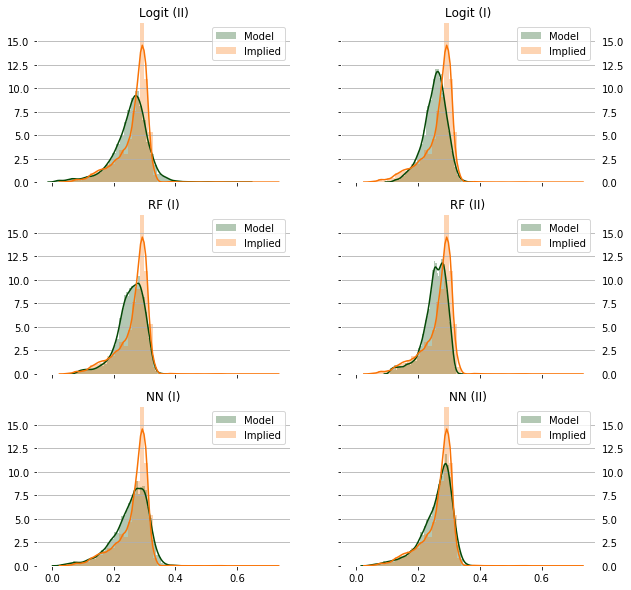

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

color = {0: 'xkcd:darkblue', 1: 'darkred',2: 'xkcd:orange', 3:'xkcd:turquoise', 4:'xkcd:darkgreen', 5:'xkcd:maroon',6:'xkcd:silver' }
def plot_dists(fig, axes, estimators, filename='dists'): 
    count = 0
    for estimator, ax in zip(estimators, fig.get_axes()): 
               # sns.distplot(prob_train[estimator], ax=ax, hist=True, kde=True, label='Model')
       # sns.distplot(odds_prob.dropna(), ax=ax, hist=True, kde=True, label = 'Implied')
        sns.distplot(prob_test[estimator], ax=ax, hist=True, color=color[4], kde=True, label='Model', hist_kws={'alpha': .3})
        sns.distplot(odds_prob_test.dropna(), ax=ax, hist=True, kde=True,color=color[2], label = 'Implied', hist_kws={'alpha': .3})
        ax.set_title(estimator)
        ax.yaxis.grid(True)
        ax.xaxis.label.set_visible(False)
        ax.legend()
        if len(estimators)>2:
            axes[count, 0].tick_params(labelleft=True)
            axes[count, -1].tick_params(labelright=True)
        count =+1
    ax.tick_params(labeltop=False, labelright=True)
    plt.rcParams['axes.edgecolor'] = 'white'
    plt.rcParams['axes.linewidth'] = 1
    plt.ylim(ymax=17)
    plt.savefig(os.getcwd() + '\\temp\\'+'%s.png' % filename, format='png',bbox_inches='tight', dpi=1000)
    
    plt.show()

fig, axes = plt.subplots(3,2, figsize=(10,10), sharey=True, sharex=True)

plot_dists(fig, axes, estimators)

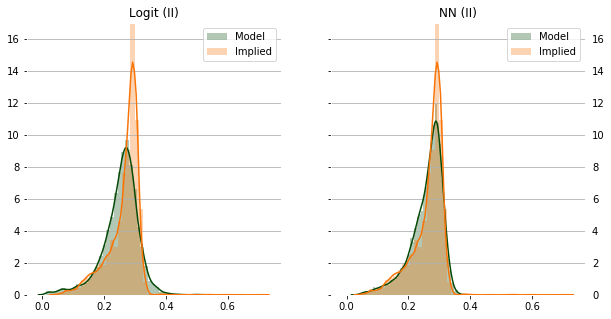

In [41]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)

two_estimators = {estimator: estimators[estimator] for estimator in ['Logit (II)', 'NN (II)']}

plot_dists(fig, axes, two_estimators, filename='dists_2')

In [ ]:
###############################################################################
#################### Feature importances #################
importances = estimators['RF (I)'].feature_importances_
std = np.std([tree.feature_importances_ for tree in estimators['RF (I)'].estimators_],
             axis=0)
imp_names = np.vstack((importances,  list(x.columns.values))).T
imp_names = imp_names[imp_names[:, 0].argsort()[::-1]]
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(x.shape[1]):
    print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))

# Feature importances plot
plt.figure()
plt.title('Feature importances', fontsize=15)
plt.bar(range(x.shape[1]), importances[indices],
       color=color[1], yerr=std[indices], align='center')
plt.xticks(range(x.shape[1]), imp_names[:,1], rotation=-90)
plt.gca().yaxis.grid(True)
plt.tick_params(labeltop=False, labelright=True)
plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams['axes.linewidth'] = 1
plt.xlim([-1, x.shape[1]])
#plt.savefig('feature_importance.eps', format='eps',bbox_inches='tight')
plt.show()

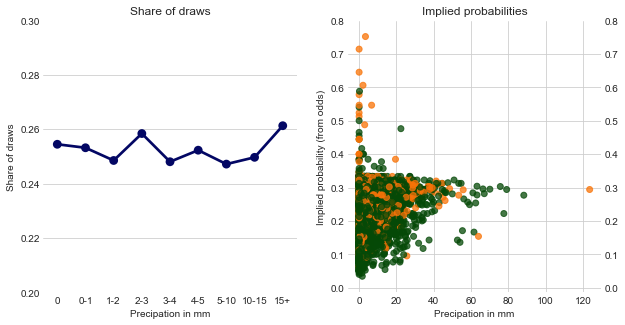

In [18]:
#data  = pd.read_csv(r'C:\Users\rbjoe\Dropbox\Kugejl\10.semester\Topics in Social Data Science\ExamProject\data\main_df.csv', index_col=0)
#data  = pd.read_csv(r'C:\Users\nynne\Dropbox\Polit\Topics in Social Data Science\ExamProject\data\main_df.csv', index_col=0)
data = data.dropna(subset=['RR'])

data['RR_grp'] = '0' 
data.loc[(data['RR']>0), 'RR_grp']='Above 0'
for i in range (0,5): 
    data.loc[(data['RR']>i) & (data['RR']<=i+1), 'RR_grp']='%s-%s' %(i,i+1)    
data.loc[(data['RR']>5) & (data['RR']<=10), 'RR_grp']='5-10'
data.loc[(data['RR']>10) & (data['RR']<=15), 'RR_grp']='10-15'
data.loc[(data['RR']>15), 'RR_grp']='15+'
#data.loc[(data['RR']>2) & (data['RR']<=3), 'RR_grp']='2-3'
#data.loc[(data['RR']>3) & (data['RR']<=4), 'RR_grp']='3-4'
#data.loc[(data['RR']>4) & (data['RR']<=5), 'RR_grp']='4-5'
#data.loc[(data['RR']>5) & (data['RR']<=6), 'RR_grp']='5-6'
#data.loc[(data['RR']>6) & (data['RR']<=7), 'RR_grp']='6-7'


#print(data['RR_grp'].value_counts()/len(data['RR_grp']))
results = pd.DataFrame()
results['RR_grp'] = data['RR_grp'].unique()




results['Draw_share'] = data.groupby('RR_grp')['draw'].mean().reset_index(drop='index')


for league in data['league'].unique(): 
    results['Draw_share_%s' %league] = data.loc[data['league']==league].groupby('RR_grp')['draw'].mean().reset_index(drop='index')

sorter = ['0', '0-1', '1-2', '2-3', '3-4', '4-5', '5-10','10-15', '15+']
sorterIndex = dict(zip(sorter,range(len(sorter))))
results['order'] = results['RR_grp'].map(sorterIndex)
results.sort_values(by='order', inplace=True)
results = results.reset_index(drop='index')

fig, ax = plt.subplots(1,2, figsize=(10,5))
color = {0: 'xkcd:darkblue', 1: 'darkred',2: 'xkcd:orange', 3:'xkcd:turquoise', 4:'xkcd:darkgreen', 5:'xkcd:maroon',6:'xkcd:silver' }

x = results['RR_grp']
y = results['Draw_share']

sns.pointplot(x,y, ax=ax[0], label='All', color=color[0])
sns.set_style("whitegrid")
sns.despine(left=True, right=True)

#
#for league in data['league'].unique(): 
#    y = results['Draw_share_%s' %league] 
#    sns.pointplot(x,y, ax=ax[0], label=league, linestyle='.')
#ax[0].legend() 
ax[0].set_title('Share of draws')
ax[0].set_ylim([0.2,0.3]) 
ax[0].set_xlabel('Precipation in mm')
ax[0].set_ylabel('Share of draws')
#ax[0].tick_params(labeltop=False, labelright=True)


x = data['RR']
y = data['odds_prob_draw']

import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [color[4], color[2]])

plt.scatter(x, y, c=data['draw'], alpha=0.75, cmap=cmap)
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
#plt.gca().yaxis.grid(True)
plt.tick_params(labeltop=False, labelright=True)
#for i in range(0,2): 
#    selector = (data['draw']==i)
#    plt.scatter(None, None, color=color[i+1], alpha=0.75, label=i, s=20)
#    
#ax[1].set_ylim([0,0.3]) 
#ax[1].set_xlim([-0.1,70]) 
ax[1].set_xlabel('Precipation in mm')
ax[1].set_title('Implied probabilities')
ax[1].set_ylabel('Implied probability (from odds)')

plt.savefig(os.getcwd() + '\\temp\\'+'wonkyweather.png', format='png',bbox_inches='tight', dpi=1000)

#plt.legend()